## Introduction
This tutorial will walk you thorugh some of the basics functionality of yieldplotlib to get you started on generating your own yield visualizations. To run yieldplotlib you need to have at least one AYO output folder, EXOSIMS output folder, or yield input package (YIP). Sample data has been provided in the tutorials folder of this repository for demonstrative purposes. 

You can also run series of premade plots for yield outputs which can be found in the scripts folder or accessed through the yieldplotlib pipeline and command line interface.

### Imports

In [57]:
from pathlib import Path

import matplotlib.pyplot as plt

import yieldplotlib as ypl
from yieldplotlib.load.ayo_directory import AYODirectory
from yieldplotlib.load.exosims_directory import EXOSIMSDirectory

### Loading Yield Data

 Yieldplotlib uses a key map to equivocate parameters between EXOSIMS and AYO (and potential future yield codes). This key map is periodically pulled from a collaborative Google Sheet to the GitHub repository in the form of a key_map.csv file. To see all the possible named parameters that can be plotted in yieldplotlib, consult the first column of that CSV file/Google Sheet. 

In order to convert this CSV to the key_map.py file that is needed by yieldplotlib to parse the yield output directories, the user should run:

`python generate_key_map.py key_map.csv`

This will populate a key_map.py file containing all the proper mappings. Now we can load our sample AYO and EXOSIMS data using the AYODirectory and EXOSIMSDirectory classes.  

In [58]:
ayo_folder = Path("sample_data/ayo")
exosims_folder = Path("sample_data/exosims")

In [59]:
ayo = AYODirectory(ayo_folder)
exosims = EXOSIMSDirectory(exosims_folder)

Loading AYODirectory ayo:   0%|          | 0/4 [00:00<?, ?item/s][yieldplotlib] INFO [2025-03-19 09:26:31,992] Loaded AYO input file: /Users/ssteiger/repos/yieldplotlib/docs/tutorials/sample_data/ayo/yield_run.ayo
[yieldplotlib] WARNING [2025-03-19 09:26:31,994] Unknown type 'str' for key 'AYO_version' at line 12. Treated as string.
[yieldplotlib] INFO [2025-03-19 09:26:32,031] Successfully parsed 60 input parameters.
Loading DRMDirectory drm: 100%|██████████| 100/100 [00:00<00:00, 26109.96item/s]
[yieldplotlib] WARNING [2025-03-19 09:26:32,044] No input files found

Loading SPCDirectory spc: 100%|██████████| 100/100 [00:00<00:00, 2995.01item/s]
[yieldplotlib] WARNING [2025-03-19 09:26:32,080] No input files found
[yieldplotlib] WARNING [2025-03-19 09:26:32,081] Unknown file type: .fits

Loading EXOSIMSCSVDirectory csv: 100%|██████████| 17/17 [00:00<00:00, 189.46item/s]
[yieldplotlib] WARNING [2025-03-19 09:26:32,173] No input files found
Loading EXOSIMSDirectory exosims:  71%|███████▏

Now that we have loaded out directories, we can display the file structure to see what is contained in our yield outputs at a glance.

In [60]:
print(exosims.display_tree())
print(ayo.display_tree())

<EXOSIMSDirectory: exosims>
├── <DRMDirectory: drm>
│   ├── <DRMFile: 91821668.pkl>
│   ├── <DRMFile: 611229025.pkl>
│   ├── <DRMFile: 150988834.pkl>
│   ├── <DRMFile: 530322504.pkl>
│   ├── <DRMFile: 534826309.pkl>
│   └── ... and 95 more
├── <SPCDirectory: spc>
│   ├── <SPCFile: 746681848.spc>
│   ├── <SPCFile: 992454934.spc>
│   ├── <SPCFile: 46942734.spc>
│   ├── <SPCFile: 773541182.spc>
│   ├── <SPCFile: 631110355.spc>
│   └── ... and 95 more
├── <EXOSIMSInputFile: Example_EXOSIMS.json>
└── <EXOSIMSCSVDirectory: csv>
    ├── <EXOSIMSCSVFile: reduce-radlum.csv>
    ├── <EXOSIMSCSVFile: reduce-earth-char-count.csv>
    ├── <JSONFile: Example_EXOSIMS.json>
    ├── <EXOSIMSCSVFile: reduce-yield-time.csv>
    ├── <EXOSIMSCSVFile: reduce-earth.csv>
    └── ... and 12 more

<AYODirectory: ayo>
├── <AYOCSVFile: target_list.csv>
├── <AYOCSVFile: coronagraph1.csv>
├── <AYOInputFile: yield_run.ayo>
└── <AYOCSVFile: observations.csv>


## Generating Plots 
Now that we have our data we can start generating plots!

### Generic Plots

yieldplotlib expands directly on matplotlib to utilize its extensive functionality as well as the familiarity many researchers have with matplotlib to make plot customization intuitive. Below are examples of some of the generic yieldplotlib plots that one can make.

[yieldplotlib] INFO [2025-03-19 09:26:32,193] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,194] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,201] Key star_dist found in target_list.csv.


Text(0.5, 1.0, 'Distribution of Star Distances')

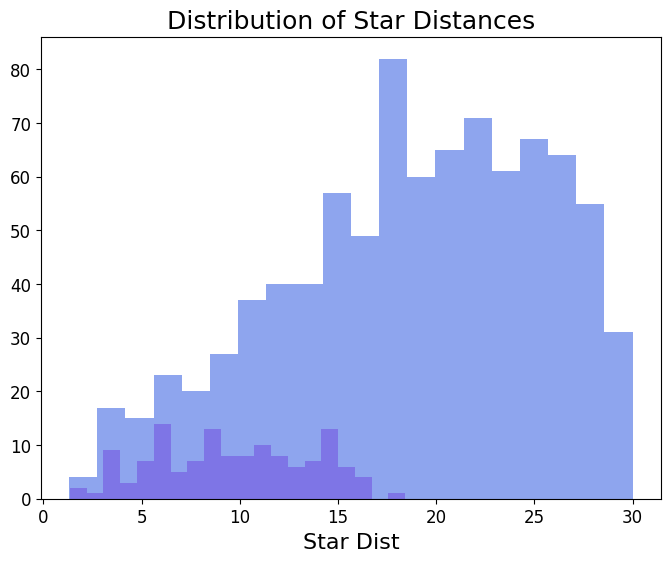

In [61]:
# Histograms

fig, ax = plt.subplots(figsize=(8, 6))
ax.ypl_hist(exosims, x="star_dist", bins=20, alpha=0.7, label="EXOSIMS Stars")
ax.ypl_hist(ayo, x="star_dist", bins=20, alpha=0.7, label="AYO Stars")
ax.set_title("Distribution of Star Distances")

[yieldplotlib] INFO [2025-03-19 09:26:32,301] Key star_dist found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,302] Key star_L found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,302] Key star_comp_det found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,321] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,322] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,325] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,326] Key star_L found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,330] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,330] Key star_comp_det found in reduce-star-target.csv.


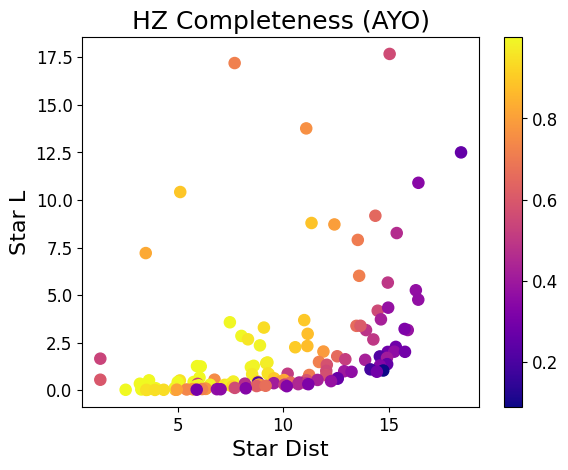

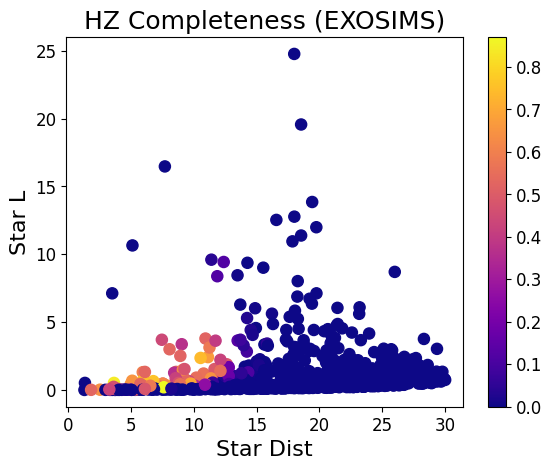

In [62]:
# Scatter Plots

fig, ax = plt.subplots()
data = ax.ypl_scatter(ayo, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (AYO)")
plt.colorbar(data)

fig, ax = plt.subplots()
data = ax.ypl_scatter(exosims, x="star_dist", y="star_L", c="star_comp_det")
ax.set_title("HZ Completeness (EXOSIMS)")
plt.colorbar(data)

### Comparative Plots 

Instead of plotting datasets individually, for comparison purposes it is often desired to plot different yield outputs in a single figure. Here the suite of available yieldplotlib comparative plots should be used. Lets see two examples plotting the same HZ completeness plots as above. 

[yieldplotlib] INFO [2025-03-19 09:26:32,550] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,551] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,554] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,555] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,558] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,559] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,563] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,564] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,567] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:26:32,568] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:26:32,571] Key modes found in Example_EXOSIMS.json.
[

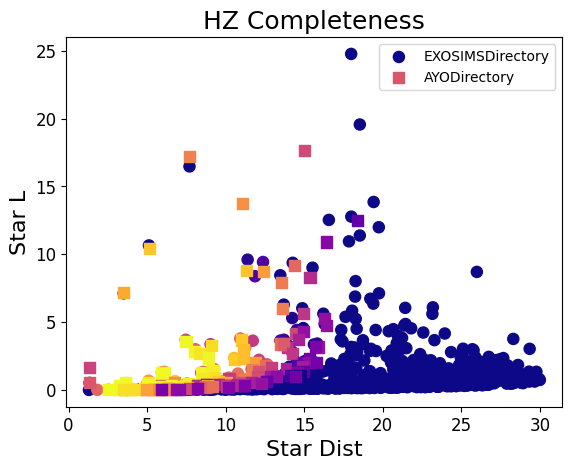

In [63]:
# Two yield runs on same set of axes.

fig, ax = plt.subplots()
ax.set_title("HZ Completeness")
data = ypl.compare(
    ax,
    [exosims, ayo],
    x="star_dist",
    y="star_L",
    plot_type="scatter",
    c="star_comp_det",
)

[yieldplotlib] INFO [2025-03-19 09:29:36,164] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:29:36,165] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:29:36,169] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:29:36,170] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:29:36,174] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:29:36,174] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:29:36,179] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:29:36,179] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:29:36,184] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:29:36,185] Key star_dist found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:29:36,188] Key modes found in Example_EXOSIMS.json.
[

(<Figure size 640x480 with 2 Axes>,
 array([[<Axes: title={'center': 'EXOSIMS'}, xlabel='Star Dist', ylabel='Star L'>,
         <Axes: title={'center': 'AYO'}, xlabel='Star Dist', ylabel='Star L'>]],
       dtype=object))

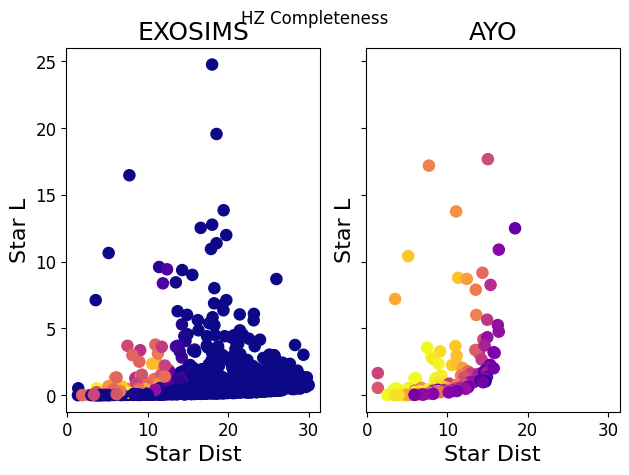

In [66]:
# Two yield runs on different sets of axes.

ypl.multi(
    [exosims, ayo],
    x="star_dist",
    y="star_L",
    plot_type="scatter",
    c="star_comp_det",
    figsize=None,
    suptitle="HZ Completeness",
    layout=None,
    sharex=True,
    sharey=True,
    titles=["EXOSIMS", "AYO"],
)

Additionally, we can run more complex analyses on multi-dimensional grids of parameter space. 

[yieldplotlib] INFO [2025-03-19 09:29:45,914] Key star_L found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,915] Key MV found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,915] Key star_L found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,915] Key MV found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,918] Key star_dist found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,919] Key MV found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,919] Key star_dist found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,920] Key MV found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,922] Key star_L found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,922] Key star_dist found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,923] Key star_L found in target_list.csv.
[yieldplotlib] INFO [2025-03-19 09:29:45,923] Key star_dist found in target_list.csv.
[yieldpl

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'MV vs star_L'}, xlabel='Star L', ylabel='Mv'>,
         <Axes: title={'center': 'MV vs star_dist'}, xlabel='Star Dist', ylabel='Mv'>],
        [<Axes: title={'center': 'star_dist vs star_L'}, xlabel='Star L', ylabel='Star Dist'>,
         <Axes: title={'center': 'star_dist vs star_dist'}, xlabel='Star Dist', ylabel='Star Dist'>]],
       dtype=object))

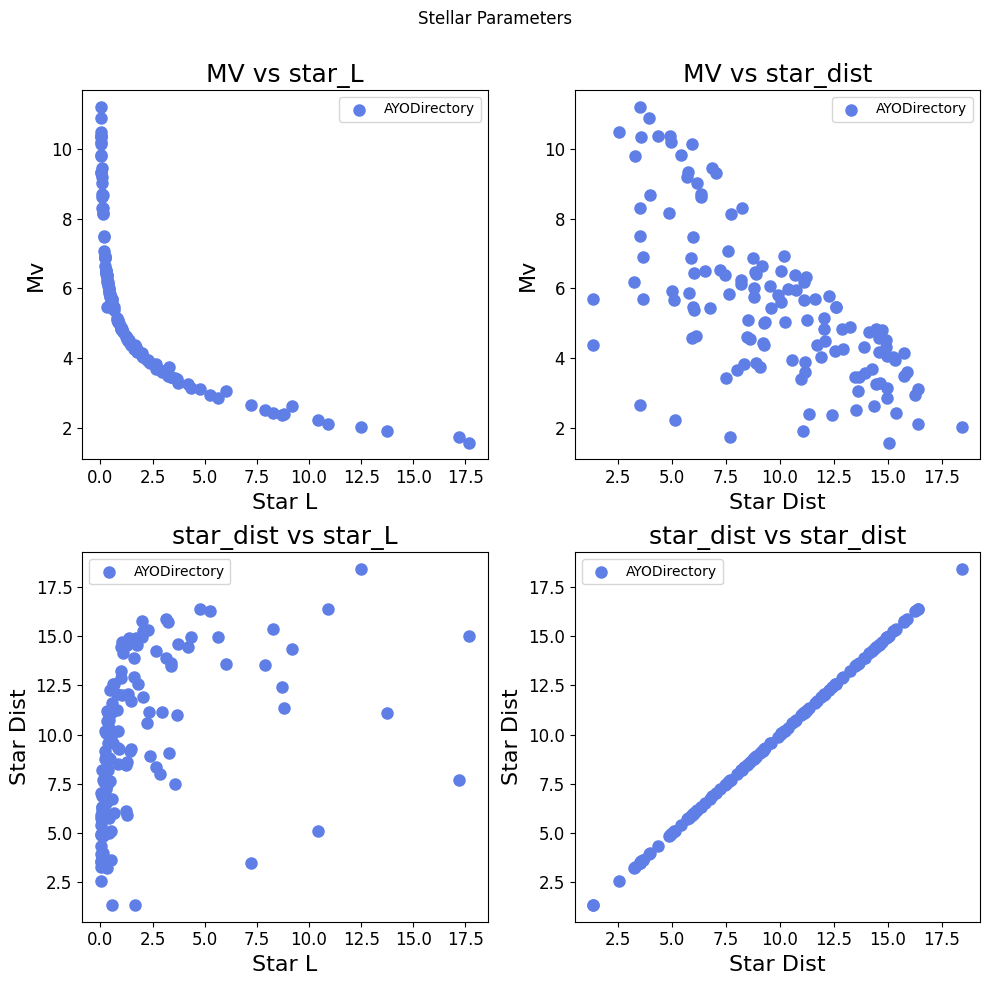

In [67]:
# Plot a grid of parameters against each other.

ypl.xy_grid(
    [ayo],
    ["star_L", "star_dist"],
    ["MV", "star_dist"],
    plot_type="scatter",
    figsize=None,
    suptitle="Stellar Parameters",
    legend=True,
    sharex=False,
    sharey=False,
    titles=None,
)

[yieldplotlib] INFO [2025-03-19 09:31:32,177] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:31:32,177] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:31:32,182] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:31:32,183] Key star_L found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:31:32,187] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:31:32,188] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:31:32,192] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:31:32,193] Key star_comp_det found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:31:32,197] Key modes found in Example_EXOSIMS.json.
[yieldplotlib] INFO [2025-03-19 09:31:32,198] Key star_L found in reduce-star-target.csv.
[yieldplotlib] INFO [2025-03-19 09:31:32,202] Key modes found in Example_EXOSIMS.json.
[yieldp

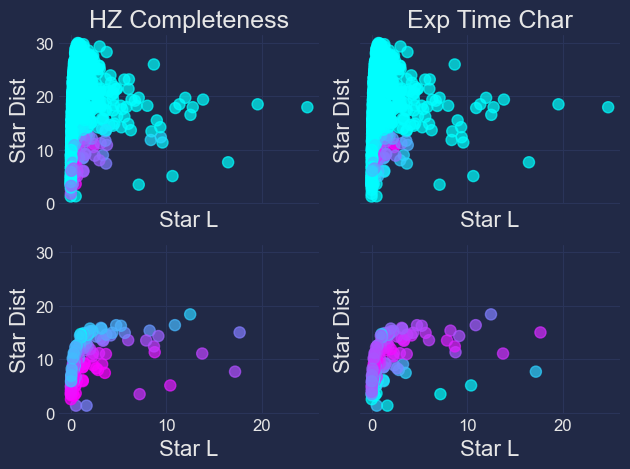

In [71]:
# Plot multiple panels with different specifications for each yield run.
# For fun, lets also make this one cyberpunk.

plt.style.use("cyberpunk")

spec1 = {
    "x": "star_L",
    "y": "star_dist",
    "plot_type": "scatter",
    "c": "star_comp_det",
    "alpha": 0.7,
}
spec2 = {
    "x": "star_L",
    "y": "star_dist",
    "plot_type": "scatter",
    "c": "exp_time_char",
    "alpha": 0.7,
}
specs = [spec1, spec2]

fig, axes = ypl.panel(
    [exosims, ayo],
    *specs,
    figsize=None,
    suptitle=None,
    layout=None,
    sharex=True,
    sharey=True,
    titles=["HZ Completeness", "Exp Time Char", "", ""],
)